In [82]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
from sklearn.preprocessing import robust_scale
from sklearn import metrics
from tabulate import tabulate
from sklearn.decomposition import PCA
from ddot import Ontology

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
sns.set()
sns.set_style("white")
sns.set_style("ticks", {"xtick.major.size":8, "ytick.major.size":8})
sns.axes_style("whitegrid")
sns.set_palette("muted")
sns.color_palette("muted")

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [3]:
plt.rcParams['svg.fonttype'] = 'none'

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
#Separating data for each drug/cell

def get_pos_map(obj_list, test_df, col):
    pos_map = {obj:[] for obj in obj_list}
    for i, row in test_df.iterrows():
        if row[col] in pos_map:
            pos_map[row[col]].append(i)
    return pos_map

In [5]:
#Arrange the obj_list in the descending order of the scores

def sort_scores(obj_list, scores):
    score_map = {}
    for i, obj in enumerate(obj_list):
        score_map[obj] = scores[i]
    return {obj:sc for obj,sc in sorted(score_map.items(), key=lambda item:item[1], reverse=True)}

In [6]:
def create_confusion_matrix(sens, res, pred_sens, pred_res):
    tp = len([c for c in pred_sens if c in sens]) + 1
    fn = len([c for c in pred_sens if c in res]) + 1
    fp = len([c for c in pred_res if c in sens]) + 1
    tn = len([c for c in pred_res if c in res]) + 1
    
    cont_table = [['Pred. Sensitive', tp, fn],
                  ['Pred. Resistant', fp, tn]]
    odds_ratio = (tp*tn)/(fn*fp)
    
    return cont_table, odds_ratio

In [7]:
def create_true_auc_waterfall(sens_df, res_df, pred_sens_df, pred_res_df, title):
    
    fig, ax = plt.subplots(figsize=(8, 8))

    data_list = []
    all_data = pd.concat([pred_sens_df, pred_res_df], axis=0, ignore_index=True)
    all_data.sort_values(by='auc', inplace=True, ignore_index=True, ascending=False)
    for _,row in all_data.iterrows():
        cell_name = str(row['cell_line'])
        
        if cell_name not in list(res_df['cell_line']) and cell_name not in list(sens_df['cell_line']):
            continue
        
        if cell_name in list(pred_res_df['cell_line']):
            data_list.append((cell_name, row['auc'], 'red'))

        if cell_name in list(pred_sens_df['cell_line']):
            data_list.append((cell_name, row['auc'], 'blue'))
            
    ax.bar([d[0] for d in data_list], [d[1] for d in data_list], color=[d[2] for d in data_list], width=1, edgecolor='none')
    ax.set_xticks([])
    ax.set_ylim((0, np.max(all_data['auc']) + 0.02))
    ax.set_xlabel('Cell lines')
    ax.set_ylabel('True AUC')
    ax.set_title(title)
    return fig

In [8]:
def plot_drug_performance(drug_corr_map, cut_off):
    fig, ax = plt.subplots(figsize=(8, 8))
    x_red = []
    y_red = []
    x_blue = []
    y_blue = []
    for d in drug_corr_map.keys():
        if drug_corr_map[d] >= cut_off:
            x_red.append(d)
            y_red.append(drug_corr_map[d])
        else:
            x_blue.append(d)
            y_blue.append(drug_corr_map[d])
    
    ratio = float(len(x_red))/float(len(drug_corr_map.keys()))
    print('Red ratio = ' + str(ratio))
    ax.bar(x_red, y_red, color='red', width=1.0, alpha=0.9)
    ax.bar(x_blue, y_blue, color='blue', width=1.0, alpha=0.9)
    ax.set_xticks([])
    ax.set_xlabel('Drugs')
    ax.set_ylabel('Performance\nSpearman ρ (Predicted vs. Actual)')
    plt.show()
    return fig

In [9]:
def create_drug_performance_plot(drugs, drug_corr_list, top=False, cut_off=0.1):
    drug_corr_map = sort_scores(drugs, drug_corr_list)
    if top:
        fig_drug_perf = plot_top_drug_performance(drug_corr_map, cut_off)
    else:
        fig_drug_perf = plot_drug_performance(drug_corr_map, cut_off)
        print('Median spearman rho:', np.median(list(drug_corr_map.values())))
    return fig_drug_perf

In [10]:
def create_scatter_plot(X, Y, x_title, y_title):
    
    idx_del = []
    for i, x in enumerate(X):
        if math.isnan(x):
            idx_del.append(i)
    for i, y in enumerate(Y):
        if math.isnan(y):
            idx_del.append(i)
    X = [x for i, x in enumerate(X) if i not in idx_del]
    Y = [y for i, y in enumerate(Y) if i not in idx_del]
    
    scatter_df = pd.DataFrame({x_title: X, y_title: Y})
    
    fig, ax = plt.subplots(figsize=(6,6))
    sns.scatterplot(data=scatter_df, x=x_title, y=y_title, s=35, ax=ax)
    
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    print('t-test', stats.ttest_ind(Y, X, alternative='greater', equal_var=False))
    
    return fig

In [11]:
def get_boxplot(df, x_title, y_title):
    
    fig, ax = plt.subplots(figsize=(9,9))
    ax.boxplot(df, showfliers=False, widths=0.5, patch_artist=True)
    ax.set_xticklabels(list(df.columns))
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    
    plt.show()
    
    return fig

In [76]:
def create_bar_chart(x, data, x_title, y_title):
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(111)
    x_pos = [i for i, _ in enumerate(x)]
    x_labels = [s for _,s in enumerate(x)]
    ax.bar(x_pos, data, align='center', alpha=1.0)
    plt.xticks(x_pos, x)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.show()
    return fig

In [77]:
def create_bar_chart_with_errors(x, data, errors, x_title, y_title):
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(111)
    x_pos = [i for i, _ in enumerate(x)]
    x_labels = [s for _,s in enumerate(x)]
    ax.bar(x_pos, data, align='center', alpha=1.0)
    ax.errorbar(x_pos, data, yerr=errors, fmt='o', color='r', capsize=10)
    plt.xticks(x_pos, x)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.show()
    return fig

In [13]:
def create_histogram(data, x_title, y_title):
    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_subplot(111)
    ax.hist(x=data, bins='auto', alpha=0.7, rwidth=0.85)
    ax.grid(False)
    ax.set_xlim(0, 1)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.show()
    return fig

In [14]:
def get_violinplot(df, x_title, y_title):
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.violinplot(df, showmedians=True)
    ax.set_xticklabels(list(df.columns), rotation=45)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    
    plt.show()
    
    return fig

In [15]:
def create_line_curve(X, Y, x_title, y_title, x_lim, y_lim):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.plot(X, Y)
    ax.grid(False)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.show()
    return fig

In [16]:
def all_models_scatterplot(performance_df, x_title, y_title):
    
    fig, ax = plt.subplots(figsize=(6, 14))
    
    performance_df.plot(kind='scatter', x='Random Forest', y='Drug', color='DarkGreen', label='Random Forest', ax=ax)
    performance_df.plot(kind='scatter', x='Multi layer perceptron', y='Drug', color='Green', label='Multi layer perceptron', ax=ax)
    performance_df.plot(kind='scatter', x='ElasticNet', y='Drug', color='LightGreen', label='ElasticNet', ax=ax)
    performance_df.plot(kind='scatter', x='DCoDR', y='Drug', color='red', label='DCoDR', s=30, ax=ax)
    
    plt.axvline(x=np.median(performance_df['DCoDR']), linestyle='--')

    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    return fig

In [17]:
def calc_std_vals(df, zscore_method):
    std_df = pd.DataFrame(columns=['smiles', 'center', 'scale'])
    std_list = []

    if zscore_method == 'zscore':
        for name, group in df.groupby(['smiles'])['auc']:
            center = group.mean()
            scale = group.std()
            if math.isnan(scale) or scale == 0.0:
                scale = 1.0
            temp = pd.DataFrame([[name, center, scale]], columns=std_df.columns)
            std_list.append(temp)

    elif zscore_method == 'robustz':
        for name, group in df.groupby(['smiles'])['auc']:
            center = group.median()
            scale = group.quantile(0.75) - group.quantile(0.25)
            if math.isnan(scale) or scale == 0.0:
                scale = 1.0
            temp = pd.DataFrame([[name, center, scale]], columns=std_df.columns)
            std_list.append(temp)
    else:
        for name, group in df.groupby(['smiles'])['auc']:
            temp = pd.DataFrame([[name, 0.0, 1.0]], columns=std_df.columns)
            std_list.append(temp)

    std_df = pd.concat(std_list, ignore_index=True)
    return std_df

In [18]:
def standardize_data(df, std_df, zscore_method):
    merged = pd.merge(df, std_df, how="left", on=['smiles'], sort=False)
    merged[zscore_method] = (merged['auc'] - merged['center']) / merged['scale']
    merged = merged[['cell_line', 'smiles', zscore_method]]
    return merged

In [19]:
def normalize_auc(train_std_df, test_df, zscore_method):

    test_std_df = calc_std_vals(test_df, zscore_method)
    for i, row in test_std_df.iterrows():
        smiles = row['smiles']
        train_entry = train_std_df.query('smiles == @smiles')
        if not train_entry.empty:
            test_std_df.loc[i, 'center'] = float(train_entry['center'])
            test_std_df.loc[i, 'scale'] = float(train_entry['scale'])
            
    test_df = standardize_data(test_df, test_std_df, zscore_method)
    return test_df

In [20]:
def print_best_params(modeldir):
    log_file = modeldir + "/train.log"
    with open(log_file, 'r') as fi:
        logs = fi.readlines()
    for i, log in enumerate(logs):
        if 'Params:' in log:
            print(logs[i+1].strip())
            print(logs[i+2].strip())
            break

In [21]:
def get_avg_cv_data(ont, dataset, zscore_method, drug, fold_size=5):
    
    avg_corr = 0.0
    fold_corr_list = []
    for i in range(1, fold_size+1):
        
        test_file = '../data/training_files_av/' + str(i) + '_test_' + dataset + '_' + drug + '.txt'
        test_df = pd.read_csv(test_file, sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
        
        modeldir = '../models/model_' + ont + '_' + dataset + '_' + drug + '_' + zscore_method + '_' + str(i) 
        pred_file = modeldir + '/predict.txt'
        try:
            pred = np.loadtxt(pred_file)
        except:
            continue
        
        corr = stats.pearsonr(test_df['auc'], pred)[0]
        fold_corr_list.append(corr)
        avg_corr += corr
        
    avg_corr /= fold_size
    return fold_corr_list, avg_corr

In [22]:
def get_avg_cv_data_alternate(method, dataset, drug, fold_size=5):
    
    avg_corr = 0.0
    fold_corr_list = []
    for i in range(1, fold_size+1):
        
        test_file = '../data/training_files_av/' + str(i) + '_test_' + dataset + '_' + drug + '.txt'
        test_df = pd.read_csv(test_file, sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
        
        modeldir = '../models/' + method
        pred_file = modeldir + '/predict' + '_' + dataset + '_' + drug + '_' + str(i) + '.txt'
        try:
            pred = np.loadtxt(pred_file)
        except:
            continue
        
        corr = stats.pearsonr(test_df['auc'], pred)[0]
        fold_corr_list.append(corr)
        avg_corr += corr
        
    avg_corr /= fold_size
    return fold_corr_list, avg_corr

In [149]:
def get_filtered_data(test_df, fraction, true_fraction, is_inverted=False):

    cell_name_map = dict()
    for i, row in test_df.iterrows():
        cell_line_name = str(row['cell_line'])
        if cell_line_name not in cell_name_map:
            cell_name_map[cell_line_name] = 1
        else:
            cell_name_map[cell_line_name] += 1
        test_df.at[i, 'cell_line'] = cell_line_name + str(cell_name_map[cell_line_name])
        
    data_size = len(test_df)
    class_size = int(data_size * fraction)
    test_df.sort_values(by='pred', inplace=True, ignore_index=True)
    if is_inverted:
        pred_res_df = test_df.iloc[ : class_size]
        pred_sens_df = test_df.iloc[data_size - class_size : data_size]
    else:
        pred_sens_df = test_df.iloc[ : class_size]
        pred_res_df = test_df.iloc[data_size - class_size : data_size]
    
    sens_samples = []
    res_samples = []
    stddev_auc = np.std(np.array(test_df['auc']))
    median_auc = np.median(np.array(test_df['auc']))
    print
    for _,row in test_df.iterrows():
        temp = pd.DataFrame([[row['cell_line'], row['auc']]], columns=['cell_line', 'auc'])

        if row['auc'] <= (median_auc):
            sens_samples.append(temp)
            
        elif row['auc'] >= (median_auc):
            res_samples.append(temp)
    
    res_df = 0
    if len(res_samples) > 0:
        res_df = pd.concat(res_samples, axis=0, ignore_index=True)
    sens_df = 0
    if len(sens_samples) > 0:
        sens_df = pd.concat(sens_samples, axis=0, ignore_index=True)
    
    #true_class_size = int(data_size * true_fraction)
    #test_df.sort_values(by='auc', inplace=True, ignore_index=True)
    #sens_df = test_df.iloc[ : true_class_size]
    #res_df = test_df.iloc[data_size - true_class_size : data_size]

    return sens_df, res_df, pred_sens_df, pred_res_df

In [24]:
def get_avg_cv_data_3class(ont, dataset, zscore_method, drug, fold_size=5, fraction=0.16, true_fraction=0.16, is_show=False):
    
    all_sens = []
    all_res = []
    all_pred_sens = []
    all_pred_res = []
    avg_corr = 0.0
    fold_corr_list = []
    for i in range(1, fold_size+1):
        
        test_file = '../data/training_files_av/' + str(i) + '_test_' + dataset + '_' + drug + '.txt'
        test_df = pd.read_csv(test_file, sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
        
        modeldir = '../models/model_' + ont + '_' + dataset + '_' + drug + '_' + zscore_method + '_' + str(i) 
        pred_file = modeldir + '/predict.txt'
        try:
            pred = np.loadtxt(pred_file)
        except:
            continue
        test_df['pred'] = pred
        sens_df, res_df, pred_sens_df, pred_res_df = get_filtered_data(test_df, fraction, true_fraction)
        filtered_df = pd.concat([pred_sens_df, pred_res_df], axis=0, ignore_index=True)
        corr = stats.pearsonr(filtered_df['auc'], filtered_df['pred'])[0]
        fold_corr_list.append(corr)
        avg_corr += corr
        
        all_sens.append(sens_df)
        all_res.append(res_df)
        all_pred_sens.append(pred_sens_df)
        all_pred_res.append(pred_res_df)

    avg_corr /= fold_size
    
    all_sens_df = pd.concat(all_sens, axis=0, ignore_index=True)
    all_res_df = pd.concat(all_res, axis=0, ignore_index=True)
    all_pred_sens_df = pd.concat(all_pred_sens, axis=0, ignore_index=True)
    all_pred_res_df = pd.concat(all_pred_res, axis=0, ignore_index=True)
    
    if is_show:
        #histogram = create_histogram(test_df['pred'], 'Cell lines', 'Predicted Drug Response (AUC)')
        fig = create_true_auc_waterfall(all_sens_df, all_res_df, all_pred_sens_df, all_pred_res_df, drug)
        cont_table, odds_ratio = create_confusion_matrix(list(all_sens_df['cell_line']), list(all_res_df['cell_line']), 
                                                     list(all_pred_sens_df['cell_line']), list(all_pred_res_df['cell_line']))
        return fold_corr_list, avg_corr, cont_table, odds_ratio, fig
    else:
        filtered_df = pd.concat([all_pred_sens_df, all_pred_res_df], axis=0, ignore_index=True)
        filtered_df['true'] = 0
        for i, row in filtered_df.iterrows():
            if str(row['cell_line']) in list(all_sens_df['cell_line']):
                filtered_df.at[i, 'true'] = -1
            elif str(row['cell_line']) in list(all_res_df['cell_line']):
                filtered_df.at[i, 'true'] = 1
            else:
                filtered_df.drop(i, axis=0, inplace=True)
        return fold_corr_list, avg_corr, filtered_df

In [25]:
def get_avg_cv_data_3class_system(ont, dataset, zscore_method, drug, system, fold_size=5, fraction=0.16, true_fraction=0.16):
    
    all_sens = []
    all_res = []
    all_pred_sens = []
    all_pred_res = []
    avg_corr = 0.0
    fold_corr_list = []
    for i in range(1, fold_size+1):
        
        test_file = '../data/training_files_av/' + str(i) + '_test_' + dataset + '_' + drug + '.txt'
        test_df = pd.read_csv(test_file, sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
        
        modeldir = '../models/model_' + ont + '_' + dataset + '_' + drug + '_' + zscore_method + '_' + str(i) 
        embedding_data = np.loadtxt(modeldir + '/hidden/' + system + '.hidden')
        pca = PCA(n_components=1)
        system_activity = pca.fit_transform(embedding_data)
        test_df['pred'] = system_activity[:, 0]
        
        is_inverted = False
        if stats.spearmanr(test_df['auc'], test_df['pred'])[0] < 0:
            is_inverted = True
        sens_df, res_df, pred_sens_df, pred_res_df = get_filtered_data(test_df, fraction, true_fraction, is_inverted=is_inverted)
        
        filtered_df = pd.concat([pred_sens_df, pred_res_df], axis=0, ignore_index=True)
        corr = stats.pearsonr(filtered_df['auc'], filtered_df['pred'])[0]
        fold_corr_list.append(corr)
        avg_corr += corr
        
        #cont_table, odds_ratio = create_confusion_matrix(list(sens_df['cell_line']), list(res_df['cell_line']), 
        #                                             list(pred_sens_df['cell_line']), list(pred_res_df['cell_line']))
        
        all_sens.append(sens_df)
        all_res.append(res_df)
        all_pred_sens.append(pred_sens_df)
        all_pred_res.append(pred_res_df)
        
    all_sens_df = pd.concat(all_sens, axis=0, ignore_index=True)
    all_res_df = pd.concat(all_res, axis=0, ignore_index=True)
    all_pred_sens_df = pd.concat(all_pred_sens, axis=0, ignore_index=True)
    all_pred_res_df = pd.concat(all_pred_res, axis=0, ignore_index=True)
    
    fig = create_true_auc_waterfall(all_sens_df, all_res_df, all_pred_sens_df, all_pred_res_df, system)
    cont_table, odds_ratio = create_confusion_matrix(list(all_sens_df['cell_line']), list(all_res_df['cell_line']), 
                                                     list(all_pred_sens_df['cell_line']), list(all_pred_res_df['cell_line']))
        
    avg_corr /= fold_size
    #return fold_corr_list, avg_corr
    return fold_corr_list, avg_corr, cont_table, odds_ratio, fig

In [26]:
def get_avg_cv_data_3class_gene(ont, dataset, zscore_method, drug, gene, fold_size=5, fraction=0.16, true_fraction=0.16):
    
    all_sens = []
    all_res = []
    all_pred_sens = []
    all_pred_res = []
    avg_corr = 0.0
    fold_corr_list = []
    for i in range(1, fold_size+1):
        
        test_file = '../data/training_files_av/' + str(i) + '_test_' + dataset + '_' + drug + '.txt'
        test_df = pd.read_csv(test_file, sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
        
        modeldir = '../models/model_' + ont + '_' + dataset + '_' + drug + '_' + zscore_method + '_' + str(i) 
        embedding_data = np.loadtxt(modeldir + '/hidden/' + gene + '.hidden')
        test_df['pred'] = embedding_data
        
        is_inverted = False
        if stats.spearmanr(test_df['auc'], test_df['pred'])[0] < 0:
            is_inverted = True
        sens_df, res_df, pred_sens_df, pred_res_df = get_filtered_data(test_df, fraction, true_fraction, is_inverted=is_inverted)
        
        filtered_df = pd.concat([pred_sens_df, pred_res_df], axis=0, ignore_index=True)
        corr = stats.pearsonr(filtered_df['auc'], filtered_df['pred'])[0]
        fold_corr_list.append(corr)
        avg_corr += corr
        
        cont_table, odds_ratio = create_confusion_matrix(list(sens_df['cell_line']), list(res_df['cell_line']), 
                                                     list(pred_sens_df['cell_line']), list(pred_res_df['cell_line']))
        
        all_sens.append(sens_df)
        all_res.append(res_df)
        all_pred_sens.append(pred_sens_df)
        all_pred_res.append(pred_res_df)
        
    #all_sens_df = pd.concat(all_sens, axis=0, ignore_index=True)
    #all_res_df = pd.concat(all_res, axis=0, ignore_index=True)
    #all_pred_sens_df = pd.concat(all_pred_sens, axis=0, ignore_index=True)
    #all_pred_res_df = pd.concat(all_pred_res, axis=0, ignore_index=True)
    
    #fig = create_true_auc_waterfall(all_sens_df, all_res_df, all_pred_sens_df, all_pred_res_df, gene)
    #cont_table, odds_ratio = create_confusion_matrix(list(all_sens_df['cell_line']), list(all_res_df['cell_line']), 
    #                                                 list(all_pred_sens_df['cell_line']), list(all_pred_res_df['cell_line']))
        
    avg_corr /= fold_size
    return fold_corr_list, avg_corr
    #return fold_corr_list, avg_corr, cont_table, odds_ratio, fig

In [54]:
def get_avg_cv_data_3class_alternate(method, dataset, drug, fold_size=5, fraction=0.16, true_fraction=0.16):
    
    avg_corr = 0.0
    fold_corr_list = []
    for i in range(1, fold_size+1):
        
        test_file = '../data/training_files_av/' + str(i) + '_test_' + dataset + '_' + drug + '.txt'
        test_df = pd.read_csv(test_file, sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
        
        modeldir = '../models/' + method
        pred_file = modeldir + '/predict' + '_' + dataset + '_' + drug + '_' + str(i) + '.txt'
        try:
            pred = np.loadtxt(pred_file)
        except:
            continue
        test_df['pred'] = pred
        
        _, _, pred_sens_df, pred_res_df = get_filtered_data(test_df, fraction, true_fraction)
        
        filtered_df = pd.concat([pred_sens_df, pred_res_df], axis=0, ignore_index=True)
        corr = stats.pearsonr(filtered_df['auc'], filtered_df['pred'])[0]
        if math.isnan(corr):
            corr = 0.0
        fold_corr_list.append(corr)
        avg_corr += corr
        
    avg_corr /= fold_size
    return fold_corr_list, avg_corr

In [28]:
def get_avg_cv_data_3class_mut(ont, dataset, zscore_method, drug, fold_size=5, fraction=0.16, true_fraction=0.16):
    
    all_test = []
    avg_corr = 0.0
    fold_corr_list = []
    for i in range(1, fold_size+1):
        
        test_file = '../data/training_files_av/' + str(i) + '_test_' + dataset + '_' + drug + '.txt'
        test_df = pd.read_csv(test_file, sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
        
        modeldir = '../../nest_drugcell/models/model_' + ont + '_' + dataset + '_' + drug + '_' + zscore_method + '_' + str(i) 
        pred_file = modeldir + '/predict.txt'
        try:
            pred = np.loadtxt(pred_file)
        except:
            continue
        test_df['pred'] = pred

        _, _, pred_sens_df, pred_res_df = get_filtered_data(test_df, fraction, true_fraction)
        
        filtered_df = pd.concat([pred_sens_df, pred_res_df], axis=0, ignore_index=True)
        corr = stats.pearsonr(filtered_df['auc'], filtered_df['pred'])[0]
        fold_corr_list.append(corr)
        avg_corr += corr
        
    avg_corr /= fold_size
    return fold_corr_list, avg_corr

In [29]:
def get_avg_cv_data_3class_cnv(ont, dataset, zscore_method, drug, fold_size=5, fraction=0.16, true_fraction=0.16):
    
    all_test = []
    avg_corr = 0.0
    fold_corr_list = []
    for i in range(1, fold_size+1):
        
        test_file = '../data/training_files_av/' + str(i) + '_test_' + dataset + '_' + drug + '.txt'
        test_df = pd.read_csv(test_file, sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
        
        modeldir = '../models/CNV/model_' + ont + '_' + dataset + '_' + drug + '_' + zscore_method + '_' + str(i) 
        pred_file = modeldir + '/predict.txt'
        try:
            pred = np.loadtxt(pred_file)
        except:
            continue
        test_df['pred'] = pred

        _, _, pred_sens_df, pred_res_df = get_filtered_data(test_df, fraction, true_fraction=0.16)
        
        filtered_df = pd.concat([pred_sens_df, pred_res_df], axis=0, ignore_index=True)
        corr = stats.pearsonr(filtered_df['auc'], filtered_df['pred'])[0]
        fold_corr_list.append(corr)
        avg_corr += corr
        
    avg_corr /= fold_size
    return fold_corr_list, avg_corr

In [30]:
def get_best_avg_corr(drugs, ont, dataset, zscore_method):
    
    best_avg = 0.0
    f_min = 0.1
    f_max = 0.5
    param_list = []
    f = f_min
    while f <= f_max:
        
        all_avg_corr = 0.0
        for i, drug in enumerate(drugs):
            corr_list, avg_corr = get_avg_cv_data_3class(ont, dataset, zscore_method, drug, fraction=f)
            all_avg_corr += avg_corr

        all_avg_corr /= len(drugs)
        if best_avg <= all_avg_corr:
            best_avg = all_avg_corr
            f_best = f

        param_list.append((f, all_avg_corr))
        print(f, all_avg_corr)
        f += 0.05

    create_line_curve([p[0] for p in param_list], [p[1] for p in param_list], 'Cut_off', 'Avg. Correlation', (f_min, f_max), (0.0, 0.3))
    return f_best

In [31]:
dataset = 'av'
zscore_method = 'auc'
ont = 'ctg'

drugs = list(pd.read_csv('../data/training_files_av/drugname_av.txt', header=None, names=['D'])['D'])
#drugs = ['Palbociclib', 'Trametinib']

In [ ]:
vnn_results_df = pd.DataFrame(index=range(len(drugs)), columns=['Drug', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5', 'Average'])

to_remove = []
for i, drug in enumerate(drugs):
    
    corr_list, avg_corr = get_avg_cv_data(ont, dataset, zscore_method, drug)
    if math.isnan(avg_corr):
        to_remove.append(drug)
        continue
    print(drug, corr_list, avg_corr)
        
drugs = [d for d in drugs if d not in to_remove]

for i, drug in enumerate(drugs):
    corr_list, avg_corr = get_avg_cv_data(ont, dataset, zscore_method, drug)
    vnn_results_df.loc[i]['Drug'] = drug
    vnn_results_df.loc[i]['Average'] = avg_corr
    for k in range(5):
        vnn_results_df.loc[i]['Fold_'+str(k+1)] = corr_list[k]

In [52]:
vnn_results_3class_df = pd.DataFrame(index=range(len(drugs)), columns=['Drug', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5', 'Average'])

#f_best = get_best_avg_corr(drugs, ont, dataset, zscore_method)
f_best=0.16
    
for i, drug in enumerate(drugs):
    corr_list, avg_corr, _ = get_avg_cv_data_3class(ont, dataset, zscore_method, drug, fraction=f_best)
    print(drug, corr_list, avg_corr)
    
    vnn_results_3class_df.loc[i]['Drug'] = drug
    vnn_results_3class_df.loc[i]['Average'] = avg_corr
    for k in range(5):
        vnn_results_3class_df.loc[i]['Fold_'+str(k+1)] = corr_list[k]

Palbociclib [0.6436811007807939, 0.5080680142703883, 0.502886775431312, 0.4877930459471347, 0.5092459178704156] 0.5303349708600089


In [ ]:
method = 'elastic_net'

elasticnet_df = pd.DataFrame(index=range(len(drugs)), columns=['Drug', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5', 'Average'])

for i, drug in enumerate(drugs):
    corr_list, avg_corr = get_avg_cv_data_alternate(method, dataset, drug)
    print(drug, corr_list, avg_corr)
    
    elasticnet_df.loc[i]['Drug'] = drug
    elasticnet_df.loc[i]['Average'] = avg_corr
    for k in range(5):
        elasticnet_df.loc[i]['Fold_'+str(k+1)] = corr_list[k]

In [55]:
method = 'elastic_net'

elasticnet_3class_df = pd.DataFrame(index=range(len(drugs)), columns=['Drug', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5', 'Average'])

for i, drug in enumerate(drugs):
    corr_list, avg_corr = get_avg_cv_data_3class_alternate(method, dataset, drug, fraction=f_best)
    print(drug, corr_list, avg_corr)
    
    elasticnet_3class_df.loc[i]['Drug'] = drug
    elasticnet_3class_df.loc[i]['Average'] = avg_corr
    for k in range(5):
        elasticnet_3class_df.loc[i]['Fold_'+str(k+1)] = corr_list[k]

Palbociclib [0.4968346924103942, 0.21326616309820343, 0.402505274512601, 0.2926638798298919, 0.3273336028972307] 0.34652072254966426


In [ ]:
method = 'random_forest'

randomforest_df = pd.DataFrame(index=range(len(drugs)), columns=['Drug', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5', 'Average'])

for i, drug in enumerate(drugs):
    corr_list, avg_corr = get_avg_cv_data_alternate(method, dataset, drug)
    print(drug, corr_list, avg_corr)
    
    randomforest_df.loc[i]['Drug'] = drug
    randomforest_df.loc[i]['Average'] = avg_corr
    for k in range(5):
        randomforest_df.loc[i]['Fold_'+str(k+1)] = corr_list[k]

In [56]:
method = 'random_forest'

randomforest_3class_df = pd.DataFrame(index=range(len(drugs)), columns=['Drug', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5', 'Average'])

for i, drug in enumerate(drugs):
    corr_list, avg_corr = get_avg_cv_data_3class_alternate(method, dataset, drug, fraction=f_best)
    print(drug, corr_list, avg_corr)
    
    randomforest_3class_df.loc[i]['Drug'] = drug
    randomforest_3class_df.loc[i]['Average'] = avg_corr
    for k in range(5):
        randomforest_3class_df.loc[i]['Fold_'+str(k+1)] = corr_list[k]

Palbociclib [0.6362016799433862, 0.418611079018525, 0.5154250979728986, 0.41293208812671733, 0.3015325516953442] 0.45694049935137426


In [ ]:
method = 'mlp'

mlp_df = pd.DataFrame(index=range(len(drugs)), columns=['Drug', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5', 'Average'])

for i, drug in enumerate(drugs):
    corr_list, avg_corr = get_avg_cv_data_alternate(method, dataset, drug)
    print(drug, corr_list, avg_corr)
    
    mlp_df.loc[i]['Drug'] = drug
    mlp_df.loc[i]['Average'] = avg_corr
    for k in range(5):
        mlp_df.loc[i]['Fold_'+str(k+1)] = corr_list[k]

In [57]:
method = 'mlp'

mlp_3class_df = pd.DataFrame(index=range(len(drugs)), columns=['Drug', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5', 'Average'])

for i, drug in enumerate(drugs):
    corr_list, avg_corr = get_avg_cv_data_3class_alternate(method, dataset, drug, fraction=f_best)
    print(drug, corr_list, avg_corr)
    
    mlp_3class_df.loc[i]['Drug'] = drug
    mlp_3class_df.loc[i]['Average'] = avg_corr
    for k in range(5):
        mlp_3class_df.loc[i]['Fold_'+str(k+1)] = corr_list[k]

Palbociclib [0.5050455234596232, 0.35034786875886637, 0.4805736042295342, 0.38068342592753923, 0.1757183986865791] 0.3784737642124284


In [ ]:
mut_vnn_results_3class_df = pd.DataFrame(index=range(len(drugs)), columns=['Drug', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5', 'Average'])

for i, drug in enumerate(drugs):
    corr_list, avg_corr = get_avg_cv_data_3class_mut(ont, dataset, zscore_method, drug, fraction=f_best)
    print(drug, corr_list, avg_corr)
    
    mut_vnn_results_3class_df.loc[i]['Drug'] = drug
    mut_vnn_results_3class_df.loc[i]['Average'] = avg_corr
    for k in range(5):
        mut_vnn_results_3class_df.loc[i]['Fold_'+str(k+1)] = corr_list[k]

In [ ]:
vnn_comp_fig = create_scatter_plot(list(mut_vnn_results_3class_df['Average']), list(vnn_results_3class_df['Average']), 
                                   'Pearson Correlation (Mutation Only)', 'Pearson Correlation (Mutation + Copy Number)')

In [ ]:
vnn_comp_fig.savefig('../plots/vnn_comparison_scatterplot_2022-03-02.svg')

In [ ]:
cnv_vnn_results_3class_df = pd.DataFrame(index=range(len(drugs)), columns=['Drug', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5', 'Average'])

for i, drug in enumerate(drugs):
    corr_list, avg_corr = get_avg_cv_data_3class_cnv(ont, dataset, zscore_method, drug, fraction=f_best)
    print(drug, corr_list, avg_corr)
    
    cnv_vnn_results_3class_df.loc[i]['Drug'] = drug
    cnv_vnn_results_3class_df.loc[i]['Average'] = avg_corr
    for k in range(5):
        cnv_vnn_results_3class_df.loc[i]['Fold_'+str(k+1)] = corr_list[k]

In [ ]:
vnn_comp_fig = create_scatter_plot(list(cnv_vnn_results_3class_df['Average']), list(vnn_results_3class_df['Average']), 
                                   'Pearson Correlation (CNV Only)', 'Pearson Correlation (Mutation + CNV)')

In [ ]:
vnn_comp_fig.savefig('../plots/figure2/cnv_comparison_scatterplot_April_03.svg')

In [ ]:
performance_df = pd.concat([vnn_results_df['Drug'], vnn_results_df['Average'], mlp_df['Average'], 
                            randomforest_df['Average'], elasticnet_df['Average']], axis=1, ignore_index=True)

performance_df.columns = ['Drug', 'DCoDR', 'Multi layer perceptron', 'Random Forest', 'ElasticNet']
performance_df.sort_values(by=['DCoDR'], inplace=True, ignore_index=True)

In [ ]:
x_title = 'Pearson Correlation'
y_title = 'Drug'
all_models_fig = all_models_scatterplot(performance_df, x_title, y_title)

In [ ]:
all_models_fig.savefig('../plots/baseline_performance_comparison_alldata.svg')

In [58]:
performance_3class_df = pd.concat([vnn_results_3class_df['Drug'], vnn_results_3class_df['Average'], mlp_3class_df['Average'], 
                            randomforest_3class_df['Average'], elasticnet_3class_df['Average']], axis=1, ignore_index=True)

performance_3class_df.columns = ['Drug', 'DCoDR', 'Multi layer perceptron', 'Random Forest', 'ElasticNet']
performance_3class_df.sort_values(by=['DCoDR'], inplace=True, ignore_index=True)

In [ ]:
x_title = 'Pearson Correlation'
y_title = 'Drug'
all_models_3class_fig = all_models_scatterplot(performance_3class_df, x_title, y_title)

In [ ]:
all_models_3class_fig.savefig('../plots/baseline_performance_comparison.svg')

In [ ]:
performance_3class_df.columns = ['Drug', 'DCoDR', 'Multi layer perceptron', 'Random Forest', 'ElasticNet']

mlp = set()
rf = set()
eln = set()

median = np.median(performance_3class_df['DCoDR'])
print('median:', median)
i = 0
for _,row in performance_3class_df.iterrows():
    
    if row['DCoDR'] < median:
        continue
    i += 1
    if row['DCoDR'] >= row['Multi layer perceptron']:
        mlp.add(row['Drug'])
        
    if row['DCoDR'] >= row['Random Forest']:
        rf.add(row['Drug'])
        
    if row['DCoDR'] >= row['ElasticNet']:
        eln.add(row['Drug'])
        
print('High performing drugs', i)

print('mlp', len(mlp))

print('rf', len(rf))

print('eln', len(eln))

print('all', len(mlp.intersection(rf).intersection(eln)))

In [ ]:
boxplot_3class_df = pd.DataFrame({
    "D-CoDR": vnn_results_3class_df['Average'], 
    "ANN": mlp_3class_df['Average'], 
    "RandomForest": randomforest_3class_df['Average'], 
    "ElasticNet": elasticnet_3class_df['Average']
})

In [ ]:
boxplot = get_boxplot(boxplot_3class_df, "", "Pearson Correlation")

In [ ]:
boxplot.savefig('../plots/figure2/boxplot_comparison_April_03.svg')

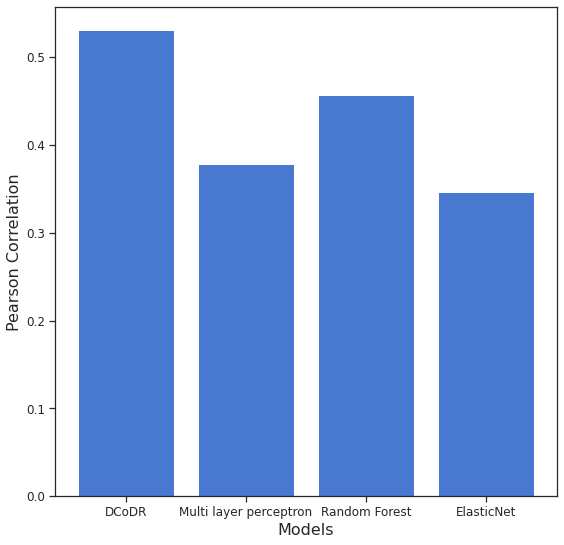

In [78]:
data = performance_3class_df.query("Drug == 'Palbociclib'").drop(['Drug'], axis=1)
x = data.columns
palbo_perf_barchart = create_bar_chart(x, data.iloc[0], 'Models', 'Pearson Correlation')

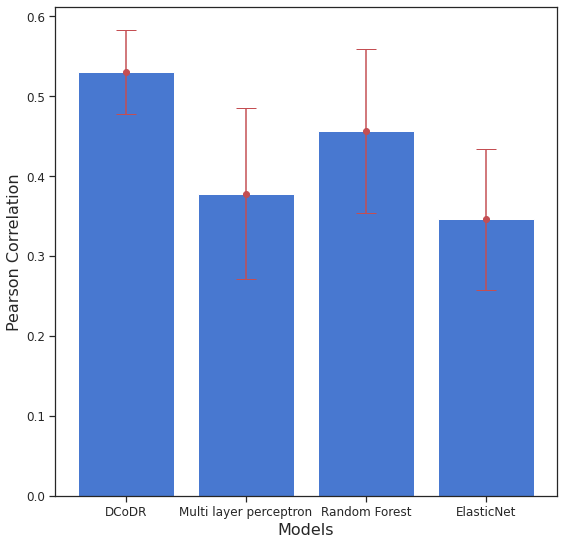

In [80]:
errors = []

vnn_std = np.std(vnn_results_3class_df.drop(['Drug'], axis=1).iloc[0])
errors.append(vnn_std)

vnn_std = np.std(mlp_3class_df.drop(['Drug'], axis=1).iloc[0])
errors.append(vnn_std)

rdf_std = np.std(randomforest_3class_df.drop(['Drug'], axis=1).iloc[0])
errors.append(rdf_std)

eln_std = np.std(elasticnet_3class_df.drop(['Drug'], axis=1).iloc[0])
errors.append(eln_std)

palbo_barchart_err = create_bar_chart_with_errors(x, data.iloc[0], errors, 'Models', 'Pearson Correlation')

In [81]:
palbo_barchart_err.savefig('../plots/figure2/palbo_barchart_error_April_25.svg')

In [108]:
float(vnn_results_3class_df['Average'])

0.5303349708600089

In [120]:
stats.ttest_ind(list(mlp_3class_df.iloc[0].drop('Drug')), list(vnn_results_3class_df.iloc[0].drop('Drug')), alternative='less')

Ttest_indResult(statistic=-2.857996263081867, pvalue=0.008507620698677639)

In [128]:
stats.ttest_ind(list(randomforest_3class_df.iloc[0].drop('Drug')), list(vnn_results_3class_df.iloc[0].drop('Drug')), alternative='less')

Ttest_indResult(statistic=-1.4260661888277386, pvalue=0.0921559385230176)

In [126]:
stats.ttest_ind(list(elasticnet_3class_df.iloc[0].drop('Drug')), list(vnn_results_3class_df.iloc[0].drop('Drug')), alternative='less')

Ttest_indResult(statistic=-4.007811834482052, pvalue=0.0012434046105236182)

Palbociclib 0.33376558125712025 [0.4188756487484425, 0.2745123653766093, 0.3670378643164689, 0.3092577664871169, 0.2991442613569635]
+-----------------+------------------+------------------+
|                 |   True Sensitive |   True Resistant |
+=================+==================+==================+
| Pred. Sensitive |              211 |               83 |
+-----------------+------------------+------------------+
| Pred. Resistant |               79 |              195 |
+-----------------+------------------+------------------+
Odds Ratio:  6.274973310965381


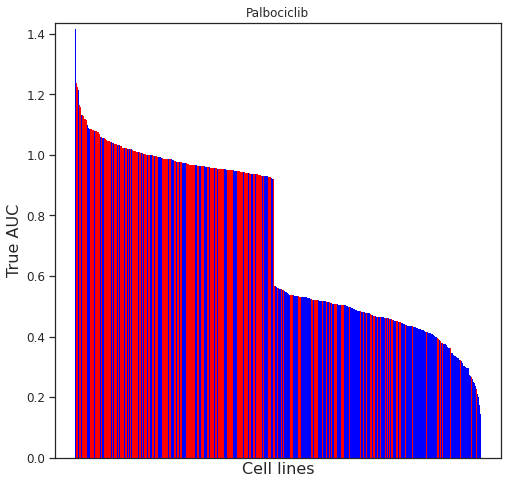

In [118]:
f_best = 0.5
drugs = ['Palbociclib']
    
for i, drug in enumerate(drugs):
    corr_list, avg_corr, cont_table, odds_ratio, waterfall_plot  = get_avg_cv_data_3class(ont, dataset, zscore_method, 
                                                                                          drug, fraction=f_best, true_fraction=0.16, is_show=True)
    print(drug, avg_corr, corr_list)
    print(tabulate(cont_table, headers=['', 'True Sensitive', 'True Resistant'], tablefmt='grid'))
    print('Odds Ratio: ', odds_ratio)

In [119]:
waterfall_plot.savefig('../plots/figure2/waterfall_pred_50_' + drug + '_April_25.svg')

AUC: 0.7869112318840581
Optimal point 0.2326388888888889 0.6956521739130435 0.76583


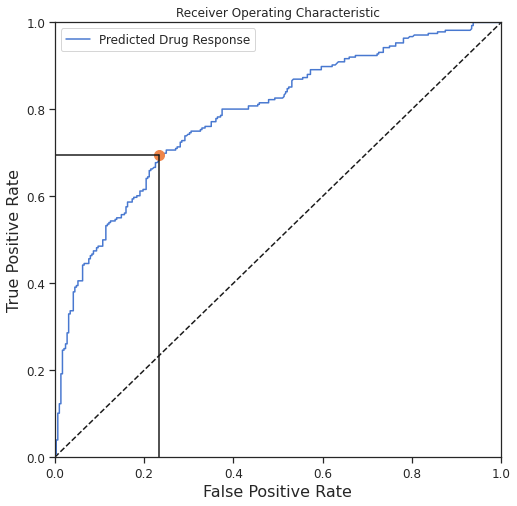

In [139]:
drugs = ['Palbociclib']
drug = 'Palbociclib'

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.grid(False)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
plt.plot([0,1],[0,1], 'k--')
f = 0.5
_, _, filtered_df  = get_avg_cv_data_3class(ont, dataset, zscore_method, drug, fraction=f, true_fraction=0.16, is_show=False)
fpr, tpr, thresholds = metrics.roc_curve(filtered_df['true'], filtered_df['pred'])
print("AUC:", metrics.roc_auc_score(filtered_df['true'], filtered_df['pred']))
plt.plot(fpr, tpr, label='Predicted Drug Response')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Receiver Operating Characteristic')

opt_i = np.argmax(tpr - fpr)
print("Optimal point", fpr[opt_i], tpr[opt_i], thresholds[opt_i])
plt.plot(fpr[opt_i], tpr[opt_i], marker='.', markersize=20)
plt.plot([fpr[opt_i], fpr[opt_i]], [0, tpr[opt_i]], 'k-')
plt.plot([0, fpr[opt_i]], [tpr[opt_i], tpr[opt_i]], 'k-')

plt.show()

In [140]:
fig.savefig('../plots/figure2/roc_curve_resistant_April_25.svg')

AUC: 0.786911231884058
Optimal point 0.30434782608695654 0.7673611111111112 -0.76513


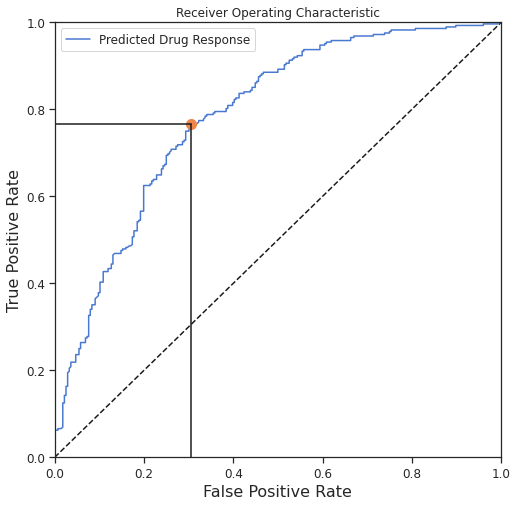

In [141]:
drugs = ['Palbociclib']
drug = 'Palbociclib'

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.grid(False)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
plt.plot([0,1],[0,1], 'k--')
f = 0.5
_, _, filtered_df  = get_avg_cv_data_3class(ont, dataset, zscore_method, drug, fraction=f, true_fraction=0.16, is_show=False)
filtered_df['pred'] = filtered_df['pred'] * -1.0
filtered_df['true'] = filtered_df['true'] * -1
fpr, tpr, thresholds = metrics.roc_curve(filtered_df['true'], filtered_df['pred'])

print("AUC:", metrics.roc_auc_score(filtered_df['true'], filtered_df['pred']))
plt.plot(fpr, tpr, label='Predicted Drug Response')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Receiver Operating Characteristic')

opt_i = np.argmax(tpr - fpr)
print("Optimal point", fpr[opt_i], tpr[opt_i], thresholds[opt_i])
plt.plot(fpr[opt_i], tpr[opt_i], marker='.', markersize=20)
plt.plot([fpr[opt_i], fpr[opt_i]], [0, tpr[opt_i]], 'k-')
plt.plot([0, fpr[opt_i]], [tpr[opt_i], tpr[opt_i]], 'k-')

plt.show()

In [142]:
fig.savefig('../plots/figure2/roc_curve_sensitive_April_25.svg')

In [138]:
thresholds

array([ 0.59601, -0.40399, -0.52219, -0.53633, -0.53923, -0.54376,
       -0.55468, -0.55564, -0.57592, -0.58949, -0.59193, -0.6009 ,
       -0.60276, -0.60645, -0.6067 , -0.6255 , -0.62555, -0.62833,
       -0.63015, -0.6314 , -0.63154, -0.63289, -0.63425, -0.63481,
       -0.63496, -0.63591, -0.63713, -0.63734, -0.63789, -0.64063,
       -0.64077, -0.64338, -0.6438 , -0.64549, -0.64793, -0.65011,
       -0.65234, -0.65301, -0.66218, -0.66297, -0.66607, -0.66713,
       -0.66726, -0.66759, -0.6678 , -0.66869, -0.67088, -0.67137,
       -0.67373, -0.67514, -0.67655, -0.67801, -0.67935, -0.68201,
       -0.68543, -0.68617, -0.68861, -0.68877, -0.69117, -0.69388,
       -0.69446, -0.69518, -0.6968 , -0.69776, -0.70163, -0.70183,
       -0.70285, -0.70301, -0.70658, -0.70777, -0.70813, -0.70891,
       -0.70977, -0.71083, -0.71107, -0.71421, -0.71461, -0.71488,
       -0.71676, -0.71711, -0.71724, -0.71738, -0.71768, -0.71818,
       -0.7194 , -0.7201 , -0.72031, -0.72046, -0.72106, -0.72

In [ ]:
f_best = 0.16
drugs = ['Palbociclib']
    
for i, drug in enumerate(drugs):
    corr_list, avg_corr, cont_table, odds_ratio, waterfall_plot_go  = get_avg_cv_data_3class('ctg_go', dataset, zscore_method, drug, fraction=f_best, is_show=True)
    print(drug, avg_corr, corr_list)
    print(tabulate(cont_table, headers=['', 'True Sensitive', 'True Resistant'], tablefmt='grid'))
    print('Odds Ratio: ', odds_ratio)

#waterfall_plot_go.savefig('../plots/waterfall_go_' + drug + '_2022-03-02.svg')

In [ ]:
ont_file = '../data/training_files_av/ontology_ctg_av.txt'
ontology = Ontology.from_table(ont_file, clixo_format=True)
terms = ontology.term_2_gene.keys()

In [145]:
drugs = ['ML-210']
    
for i, drug in enumerate(drugs):
    
    corr_list, avg_corr = get_avg_cv_data(ont, dataset, zscore_method, drug)
    print(drug, corr_list, avg_corr)

ML-210 [0.42432782633153593, 0.30327461991117527, 0.19674567543058413, 0.10666585315967911, 0.3199198297062051] 0.27018676090783594


In [150]:
f_best=0.16
    
for i, drug in enumerate(drugs):
    corr_list, avg_corr, _ = get_avg_cv_data_3class(ont, dataset, zscore_method, drug, fraction=f_best)
    print(drug, corr_list, avg_corr)

ML-210 [0.6042164573413595, 0.4708865558756253, 0.30839519589407466, 0.15012437228819273, 0.40458994951948807] 0.387642506183748
